In [1]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
import keras
import pandas as pd
import os, shutil
import useful_functions as uf
from loss_functions import sigma_loss, sigma_f_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma

2023-06-10 14:59:06.946383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 14:59:08.152003: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-10 14:59:08.152128: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-10 14:59:08.152144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
home_dir="/home/amorelli/r_estimate/foreground_B/7b_6_23/"
load_dir='/home/amorelli/r_estimate/foreground_B/' 
to_load="test_data_r_0_001_t006_40.npz"
loss_training=sigma_log_loss 
checkpoint_dir=home_dir+"checkpoints"
last=-1

In [3]:
f=np.load(load_dir+to_load)
x_test=f["x_test"]
y_test=f["y_test"]
y_test,x_test=uf.unison_sorted_copies(y_test,x_test)

In [4]:
n_layer_0=48
n_layer_1=256
n_layer_2=16
nside=16
drop=0.2
one_layer=True
shape = (hp.nside2npix(nside), 2)
inputs = tf.keras.layers.Input(shape)
# nside 16 -> 8
x=inputs
for k in range(4):
    x = nnhealpix.layers.ConvNeighbours(nside//2**k, filters=32, kernel_size=9)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = nnhealpix.layers.Dgrade(nside//2**k, nside//2**(k+1))(x) # i use 4 convolutional layers, for each layer i decrease the number of pixels by 1/2
# dropout
x = tf.keras.layers.Dropout(drop)(x)
x = tf.keras.layers.Flatten()(x)
if one_layer==True:# depending on the state os one_layer i create a NN with one layer or with two layers
    x = tf.keras.layers.Dense(n_layer_0)(x)
    x = tf.keras.layers.Activation('relu')(x)
    out = tf.keras.layers.Dense(2)(x)
else:
    x = tf.keras.layers.Dense(n_layer_1)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(drop)(x)
    x = tf.keras.layers.Dense(n_layer_2)(x)
    x = tf.keras.layers.Activation('relu')(x)
    out = tf.keras.layers.Dense(2)(x)
tf.keras.backend.clear_session()
model = tf.keras.models.Model(inputs=inputs, outputs=out)
model.compile(loss=loss_training, optimizer=tf.optimizers.Adam(),metrics=metrics)

2023-06-10 14:59:11.617483: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-10 14:59:11.617792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coka.fe.infn.it): /proc/driver/nvidia/version does not exist
2023-06-10 14:59:11.619531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
files=os.listdir(checkpoint_dir)
files.sort()
checkpoint_path=files[last]
model.load_weights(checkpoint_dir+'/'+ checkpoint_path)

In [6]:
#results=model.evaluate(x,y,verbose=2)
predictions=model.predict(x_test)

313/313 [==============================] - 7s 20ms/step


In [7]:
predictions=predictions[:,0]

tau_pred=predictions[:,0]
sigma_pred=np.abs(predictions[:,1])#*predictions[:,1]
tau_est=np.mean(tau_pred)
sigma_tau=np.std(tau_pred)**2
#sigma_tau=np.sum((tau_pred-0.06)**2)/10000
sigma_est=np.mean(sigma_pred)
counts_tau, bins_tau = np.histogram(tau_pred)
counts_sigma, bins_sigma = np.histogram(sigma_pred)

In [8]:
bias=[]
y_bias=[] #y_test compressed so that i have only once each value of y_test
y_count=[] #number of equal y in y_test for each element in above array
prev_index=0
b=0
p=0
pred=[]
for i in range(1,len(y_test)):
    if y_test[i] != y_test[i-1]:
        y_count.append(i-prev_index)
        prev_index=i
        y_bias.append(y_test[i-1])
        b/=y_count[-1]
        p/=y_count[-1]
        bias.append(b)
        pred.append(p)
        b=0
    else:
        b+=y_test[i]-predictions[i]
        p+=predictions[i]

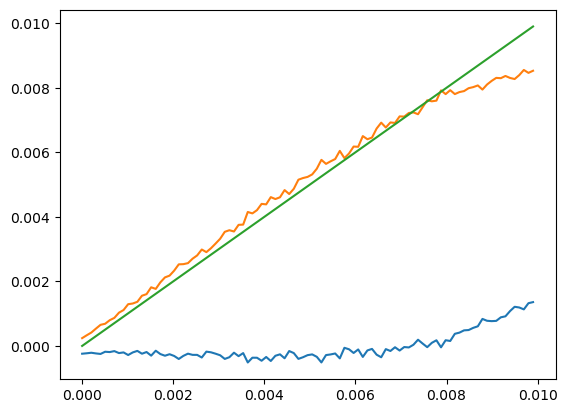

In [9]:
plt.plot(y_bias,bias)
plt.plot(y_bias,pred)
plt.plot(y_bias,y_bias)